# Chapter 3
## Classification

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', as_frame = False)

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

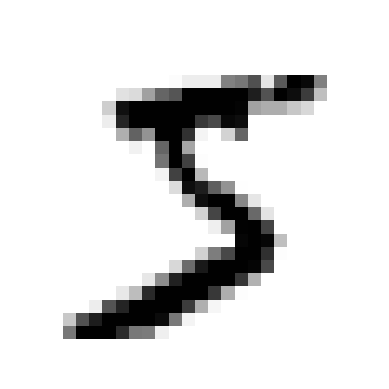

In [10]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [11]:
y[0]

'5'

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### A Binary Classifier

For simplicity let's just see if a given digit is 5 or not. This "5-detector" will be an example of a binary classifier.

In [15]:
#create target vectors.

y_train_5 = (y_train == '5') #True for all 5(s), else, false.
y_test_5 = (y_test == '5')

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Looks good, right? But here's a twist, there are only about 10% 5s in the whole data set, so even if you guess all images are not a 5, you'll still be about 90% correct.

To check this let's use the dummy classifier that classifies all images to the most frequent class only, in this case, non-5.

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [25]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

See? 90%

This is why accuracy is not a preferred measure for classifiers, especially with skewed datasets like this where some classes are much more frequent.

In [47]:
#Cross validation, with a little more control.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [49]:
skfolds = StratifiedKFold(n_splits = 3) #Add shuffle = True if the dataset is not shuffled

In [57]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


<hr>

### Confusion Matrices

In [60]:
from sklearn.model_selection import cross_val_predict

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [63]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [66]:
from sklearn.metrics import confusion_matrix

In [68]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

<hr>

$$
\begin{bmatrix}
TN & FP
\\
FN & TP
\end{bmatrix}
$$


A perfect CM will have only diagonal non-zero values and all values off the diagonal will be zero.

<hr>

In [77]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

<hr>

- Precision: Accuracy of positive predictions
    - precision = $\frac{TP}{TP+FP}$
    
<br>

- Recall: Also called sensitivity or the true positive rate
    - recall = $\frac{TP}{TP+FN}$

In [95]:
from sklearn.metrics import precision_score, recall_score

In [97]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [99]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

To combine precision and recall into a single metric makes sense.

$F_1$ score is the harmonic mean of precision and recall. (Because harmonic mean gives much more weight to lower values). $F_1$ will be high if both P and R are high.

$F_1 = \frac{2}{\frac{1}{P}+\frac{1}{R}} = 2 \times \frac{P \times R}{P+R} = \frac{TP}{TP+\frac{FN+FP}{2}}$

In [105]:
from sklearn.metrics import f1_score

In [107]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [109]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [120]:
threshold = 2164
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [122]:
#How do we know what threshold to use?

In [124]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [126]:
from sklearn.metrics import precision_recall_curve

In [128]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

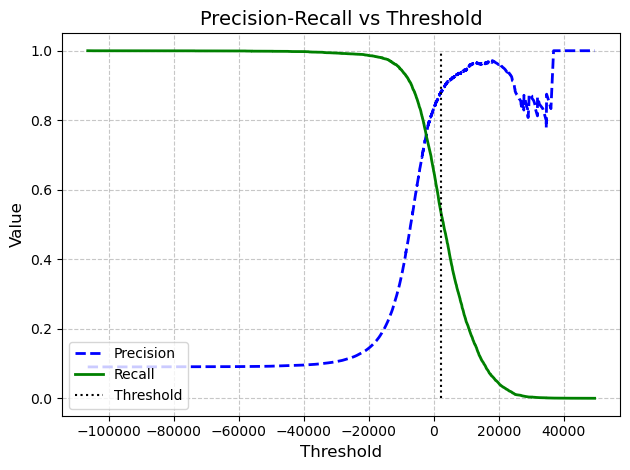

In [142]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1],"g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k","dotted", label="Threshold")
plt.title("Precision-Recall vs Threshold", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="lower left", fontsize=10)
plt.tight_layout()
plt.show()

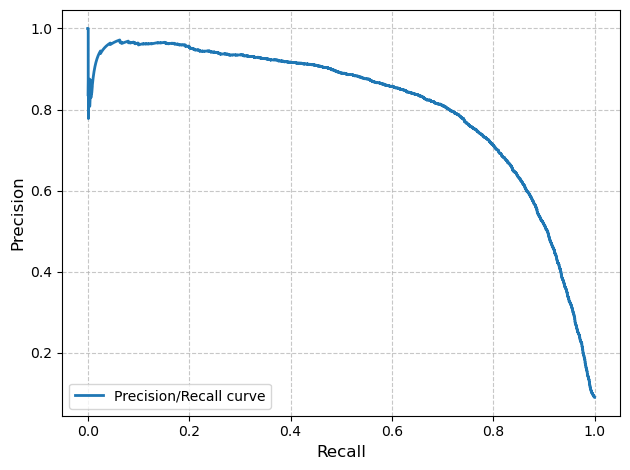

In [146]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="lower left", fontsize=10)
plt.tight_layout()
plt.show()

In [148]:
idx_for_90_precision = (precisions>=0.90).argmax()

In [150]:
threshold_for_90_precision = thresholds[idx_for_90_precision]

In [152]:
threshold_for_90_precision

3370.0194991439557

In [154]:
y_train_pred_90 = (y_scores>=threshold_for_90_precision)

In [156]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [158]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

In [161]:
recall_at_90_precision

0.4799852425751706

### The ROC Curve
Receiver Operating Characteristic

$\frac{TPR}{FPR} = \frac{TPR}{1-TNR}$

sensitivity/(1-specificity)

In [170]:
from sklearn.metrics import roc_curve

In [172]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [174]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

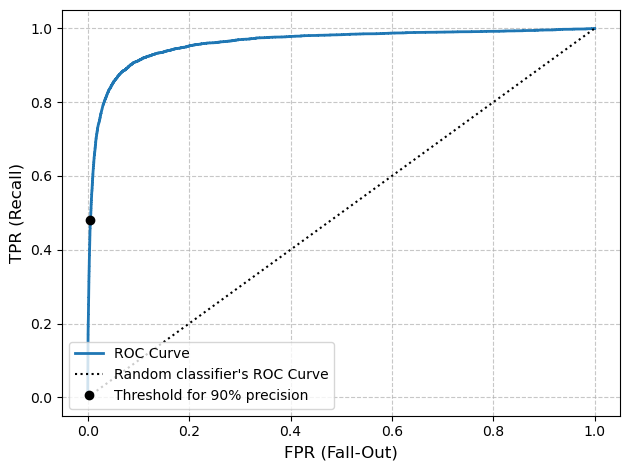

In [176]:
plt.plot(fpr,tpr,linewidth=2,label="ROC Curve")
plt.plot([0,1],[0,1], 'k:', label="Random classifier's ROC Curve")
plt.plot([fpr_90],[tpr_90],"ko", label="Threshold for 90% precision")
plt.xlabel("FPR (Fall-Out)", fontsize=12)
plt.ylabel("TPR (Recall)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="lower left", fontsize=10)
plt.tight_layout()
plt.show()

In [178]:
from sklearn.metrics import roc_auc_score

In [180]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [182]:
from sklearn.ensemble import RandomForestClassifier

In [184]:
forest_clf = RandomForestClassifier(random_state=42)